In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sns

In [18]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [19]:
import LB_colony_growth.LB_colony_growth as lb

import skimage as ski
import skimage.draw

In [20]:
dimension = 2

workgroup_x = 32
workgroup_y = 16

halo = 1 #ALWAYS 1 for this system.

num_alleles = 2

nx = 128
ny = 128

velocity_set = 'D2Q9'

In [21]:
bc_map = np.zeros((nx + 2*halo, ny + 2*halo), dtype=lb.int_type)

bc_map[...] = lb.FLUID_NODE

bc_map[0:halo, :] = lb.WALL_NODE
bc_map[-halo:, :] = lb.WALL_NODE
bc_map[:, 0:halo] = lb.WALL_NODE
bc_map[:, -halo:] = lb.WALL_NODE

In [22]:
R0 = 10

[r, c] = ski.draw.circle(nx/2, ny/2, R0)

rand_alleles = np.random.randint(-num_alleles, 0, size=(nx, ny))

In [23]:
bc_map[r, c] = rand_alleles[r, c]

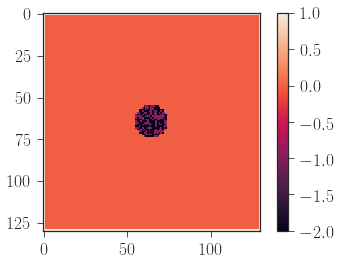

In [24]:
plt.imshow(bc_map)
plt.colorbar()

In [25]:
ctx_info = {}
ctx_info['num_type'] = 'double'

ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = None

ctx_info['local_size'] = (workgroup_x, workgroup_y)
ctx_info['domain_size'] = (nx, ny)

ctx_info['dimension'] = dimension
ctx_info['num_alleles'] = num_alleles

ctx_info['kernel_arguments'] = {}

In [36]:
k_list = [.01, .01]
m_reproduce_list = [1, 1]
velocity_set = 'D2Q9'
D = .5 * (1./3.)

In [37]:
dla_colony = lb.DLA_Colony(
    ctx_info=ctx_info, velocity_set='D2Q9',
    bc_map=bc_map, 
    D=D, k_list=k_list, m_reproduce_list=m_reproduce_list)

global size: (128, 128)
local size: (32, 16)
The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192L, 8192L, 8192L]
---------------------------
This context is associated with  1 devices
tau 1.0
omega 1.0
global_size_bc: (160, 144)


LB_colony_growth/LB_colony_growth.py:477: UserWarning: Received OpenCL source code in Unicode, should be ASCII string. Attempting conversion.
  print '---------------------------'


In [34]:
dla_colony.kernel_args

{'D': 0.16666666666666666,
 'bc_map': <pyopencl.cffi_cl.Buffer at 0x7fb26af829d0>,
 'bc_map_streamed': <pyopencl.cffi_cl.Buffer at 0x7fb26af82f90>,
 'buf_nx': 34,
 'buf_ny': 18,
 'buf_nz': None,
 'c_mag': <pyopencl.cffi_cl.Buffer at 0x7fb26af82a10>,
 'c_vec': <pyopencl.cffi_cl.Buffer at 0x7fb26af82d10>,
 'cs': 0.57735026918962584,
 'f': <pyopencl.cffi_cl.Buffer at 0x7fb26ee3a410>,
 'f_streamed': <pyopencl.cffi_cl.Buffer at 0x7fb26ee42f50>,
 'feq': <pyopencl.cffi_cl.Buffer at 0x7fb26af82f50>,
 'halo': 1,
 'k_list': <pyopencl.cffi_cl.Buffer at 0x7fb26ee68d50>,
 'm_reproduce_list': <pyopencl.cffi_cl.Buffer at 0x7fb26af82ad0>,
 'nx_bc': 130,
 'ny_bc': 130,
 'nz_bc': None,
 'omega': 1.0000000000000002,
 'reflect_index': <pyopencl.cffi_cl.Buffer at 0x7fb26af82850>,
 'rho': <pyopencl.cffi_cl.Buffer at 0x7fb26af82c90>,
 'slip_index': <pyopencl.cffi_cl.Buffer at 0x7fb26af82f10>,
 'tau': 0.99999999999999978}